In [74]:
from sklearn.mixture import GaussianMixture
import cv2
import imageio
import numpy as np
import pdb
import math
import pylab as plt

import sys
sys.path.append("../");
import superpixels as sp
from helpers import get_smaller_image

filename = '../data/toothpick.mp4'
vid = imageio.get_reader(filename, 'ffmpeg')

In [90]:
def process_superpixel(superpixel):
    """ Process superpixel for training data
    """
    return superpixel

def calculate_score(clf_o, clf_b, superpixel):
    score_o = math.exp(clf_o.score(np.array(superpixel)))
    score_b = math.exp(clf_b.score(np.array(superpixel)))
#     return (score_o / (score_o + score_b))
    if (score_o + score_b) == 0:
        return 0
    else:
        return (score_o / (score_o + score_b))
    
def display_superpixels(image, mask, sp_ids):
    out = np.zeros(image.shape).astype(np.uint8) # astype is needed otherwise show weird colors.
    idx = np.zeros(mask.shape)
    for i in sp_ids:
        idx = (mask==i)
        out[idx] = image[idx]
    plt.imshow(out)

In [91]:
# List of superpixel maps 
maps_list = []

# List of Edge Adjacency Matrix
W = []

# List of ID of superpixel that overlaps with the fixation point
obj_ids = []

for i in range(1):
    image = get_smaller_image(vid, i)
    sp.num_superpixels = 100
    maps = sp.extract_superpixels(image)
    maps_list.append(maps)

    # fixation point is assumed to be at the center of the image.
    fp = maps[int(image.shape[0]/2.0), int(image.shape[1]/2.0)]
    obj_ids.append(fp)


# Learn background and object color models
clf_b = GaussianMixture(n_components=1, random_state=42)
clf_o = GaussianMixture(n_components=1, random_state=42)

for m, maps in enumerate(maps_list):
    max_sp_id = np.max(maps)
    obj_id = obj_ids[m]
    image = get_smaller_image(vid, i)
    for i in range(max_sp_id+1):
        superpixel = image[maps == i]
        if i == obj_id:
            clf_o.fit(process_superpixel(superpixel))
        else:
            clf_b.fit(process_superpixel(superpixel))
    print(clf_o.means_)
    print(clf_b.means_)

[[ 76.11658654  75.87259615  68.45552885]]
[[ 143.32792208  137.42316017  120.57251082]]


In [92]:
obj_ids

[42]

In [93]:
print(clf_b.weights_)
print(clf_b.means_)
print(clf_b.covariances_)

[ 1.]
[[ 143.32792208  137.42316017  120.57251082]]
[[[ 106.54290101  101.53547886  102.77762903]
  [ 101.53547886  101.099075    103.13544185]
  [ 102.77762903  103.13544185  108.40708084]]]


In [94]:
print(clf_o.weights_)
print(clf_o.means_)
print(clf_o.covariances_)

[ 1.]
[[ 76.11658654  75.87259615  68.45552885]]
[[[ 2004.00563935  2017.26004588  2058.81107416]
  [ 2017.26004588  2041.93208657  2084.49974286]
  [ 2058.81107416  2084.49974286  2132.07614832]]]


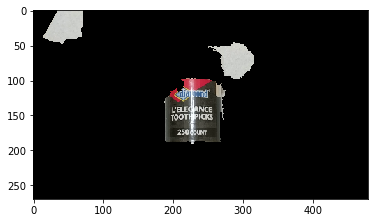

In [96]:
# Just going to do inference on the first image to see how it works.
m = 0
maps = maps_list[0]

# IDs of superpixels to display
show_sp_ids = []
threshold = 1
    
max_sp_id = np.max(maps)
obj_id = obj_ids[m]
image = get_smaller_image(vid, 0)
scores = []
for i in range(max_sp_id+1):
        superpixel = image[maps == i]
#         print(superpixel)
        score = calculate_score(clf_o, clf_b, superpixel)
#         if i == obj_id:
#             print("SHOULD BE OBJECT")
#         print(score)
        scores.append(score)
        if score >= threshold:
            show_sp_ids.append(i)
# print(scores)
display_superpixels(image, maps, show_sp_ids)
plt.show()